In [128]:
import pandas as pd
import matplotlib.pylab as plt
import requests
import numpy as np
import seaborn as sns

import missingno as msno
import datetime

import ee
# ee.Authenticate()
ee.Initialize()

## Download Streamflow data
San Lorenzo River, Santa Cruz County, California
USGS streamflow data is in *local* time... so loses an hour or missing an hour at each time zone. Change data to be in PST so it matches clock time in the winter when the most "action" is. 

In [129]:
def download_usgs_data(site, code1, code2, startDT, endDT):
    
    usgs_water_api = ("https://waterservices.usgs.gov/nwis/iv/?format=json&sites=" + site +  "&parameterCd=" + code1 + "," + code2 + 
                  "&siteStatus=all&startDT=" + startDT + "&endDT=" + endDT)
    api_response = requests.get(usgs_water_api)
    
    water_data = api_response.json()
    flow_data = pd.DataFrame(water_data['value']['timeSeries'][0]['values'][0]['value']).sort_values('dateTime')
    stage_data = pd.DataFrame(water_data['value']['timeSeries'][1]['values'][0]['value']).sort_values('dateTime')
    
    
    streamflow_raw = pd.merge(flow_data, stage_data, how='outer', on='dateTime')

    return streamflow_raw

In [130]:
#import streamflow data for San Lorenzo River at Big Trees
site = '11160500'
code1 = '00060'
code2 = '00065'
startDT = '1987-10-01T00:00:00.000-07:00'
endDT = '2024-06-18T00:00:00.000-07:00'

streamflow_BT_raw = download_usgs_data(site, code1, code2, startDT, endDT)
streamflow_BT_raw.head()


value_x qualifiers_x                       dateTime value_y qualifiers_y
0    9.40    [A, [91]]  1987-10-01T00:15:00.000-07:00     NaN          NaN
1    9.40    [A, [91]]  1987-10-01T00:30:00.000-07:00     NaN          NaN
2    9.40    [A, [91]]  1987-10-01T00:45:00.000-07:00     NaN          NaN
3    9.40    [A, [91]]  1987-10-01T01:00:00.000-07:00     NaN          NaN
4    9.40    [A, [91]]  1987-10-01T01:15:00.000-07:00     NaN          NaN

In [131]:
# import Santa Cruz streamflow data for San Lorenzo River
site = '11161000'
code1 = '00060'
code2 = '00065'
startDT = '1987-10-01T00:00:00.000-07:00'
endDT = '2024-06-18T00:00:00.000-07:00'

streamflow_SC_raw = download_usgs_data(site, code1, code2, startDT, endDT)
streamflow_SC_raw.head()


value_x qualifiers_x                       dateTime value_y qualifiers_y
0    4.40    [A, [91]]  1987-10-01T00:15:00.000-07:00     NaN          NaN
1    4.40    [A, [91]]  1987-10-01T00:30:00.000-07:00     NaN          NaN
2    3.90    [A, [91]]  1987-10-01T00:45:00.000-07:00     NaN          NaN
3    3.70    [A, [91]]  1987-10-01T01:00:00.000-07:00     NaN          NaN
4    3.20    [A, [91]]  1987-10-01T01:15:00.000-07:00     NaN          NaN

In [132]:
# combine streamflow data into one df

def process_streamflow(streamflow_data, flood_stage_bins):
    #create datetime index
    streamflow_data.index = pd.to_datetime([x[0:-6] for x in streamflow_data['dateTime']]) 

    # convert data to PST (-08:00) 
    streamflow_data['tz'] = [x[-6::] for x in streamflow_data['dateTime']]
    streamflow_data.loc[streamflow_data.tz == '-07:00', :].index = streamflow_data.loc[streamflow_data.tz == '-07:00', :].index - pd.Timedelta(1, 'hour')

    #rename cols
    col_mapper = {'value_x': 'q_cfs', 'qualifiers_x': 'code_q', 'value_y': 'stage_ft', 'qualifiers_y': 'code_stage'}
    streamflow_data.rename(col_mapper, axis=1, inplace=True) # rename cols

    #cfs to numeric 
    streamflow_data[['stage_ft', 'q_cfs']] = streamflow_data[['stage_ft', 'q_cfs']].apply(pd.to_numeric)

    # resample to 15 min to account for timechange dupes
    streamflow_data_resample = streamflow_data.resample('15min').agg({'q_cfs': 'mean',
                                                                     'stage_ft': 'mean',
                                                                     'code_q': 'first', 
                                                                     'code_stage': 'first', 
                                                                     'dateTime': 'first', 
                                                                     'tz': 'first'})

    streamflow_data_resample.drop(['dateTime'], axis=1, inplace=True)

    streamflow_data_resample = streamflow_data_resample.resample('1D').agg({'q_cfs': 'max',
                                                                         'stage_ft': 'max',
                                                                         'code_q': 'first', 
                                                                         'code_stage': 'first', 
                                                                             'tz': 'first'})

    streamflow_data_resample.rename({'q_cfs': 'q_cfs_peak'}, axis=1, inplace=True)

    streamflow_data_resample['flood_stage'] = pd.cut(streamflow_data_resample['stage_ft'], flood_stage_bins, labels=False)
    
    return streamflow_data_resample

flood_stage_bins_BT = np.array([0, 14, 16.5, 19.5, 21.76, 999]) # https://water.noaa.gov/gauges/btec1
streamflow_BT = process_streamflow(streamflow_BT_raw, flood_stage_bins_BT)

flood_stage_bins_SC = np.array([0, 18, 20.55, 23.33, 25.0, 999]) # https://water.noaa.gov/gauges/lrrc1
streamflow_SC = process_streamflow(streamflow_SC_raw, flood_stage_bins_BT)


streamflow = pd.merge(streamflow_BT, streamflow_SC, how='outer', left_index=True, right_index=True, suffixes=['_BT', '_SC'])

streamflow.dropna().head()

q_cfs_peak_BT  stage_ft_BT  code_q_BT code_stage_BT   tz_BT  \
2007-10-01           12.2         3.05  [A, [91]]           [A]  -07:00   
2007-10-02           12.7         3.06        [A]           [A]  -07:00   
2007-10-03           12.2         3.05        [A]           [A]  -07:00   
2007-10-04           12.2         3.05        [A]           [A]  -07:00   
2007-10-05           13.1         3.07        [A]           [A]  -07:00   

            flood_stage_BT  q_cfs_peak_SC  stage_ft_SC  code_q_SC  \
2007-10-01             0.0           2.72         3.99  [A, [91]]   
2007-10-02             0.0           3.86         4.05        [A]   
2007-10-03             0.0           3.55         4.03        [A]   
2007-10-04             0.0           2.47         3.98        [A]   
2007-10-05             0.0           2.98         4.01        [A]   

           code_stage_SC   tz_SC  flood_stage_SC  
2007-10-01           [A]  -07:00             0.0  
2007-10-02           [A]  -07:00             0.0  
2007-10-03           [A]  -07:00             0.0  
2007-10-04           [A]  -07:00             0.0  
2007-10-05           [A]  -07:00             0.0

## download precipitation data from Ben Lomond Station near Felton, CA within the San Lorenzo watershed. 
Data is event-based data, with timestamp saved for each tip of the rain tipping bucket. Code below recalculated to incremental data resampled to every 15 minutes. 

In [133]:
#download Ben Lomond precip data
cdec_bl_api = 'https://cdec.water.ca.gov/dynamicapp/req/JSONDataServlet?Stations=BLN&SensorNums=16&dur_code=E&Start=1997-12-10&End=2024-06-18'

response = requests.get(cdec_bl_api)
rain_data = response.json()


In [134]:
## clean event-based rain data (tip events to 15 minute data)
event_rain = pd.DataFrame(rain_data)
event_rain['dt'] = pd.to_datetime(event_rain['date'])
event_rain['inc'] = event_rain['value'].diff()

event_rain.sort_values('inc')
event_rain_cleaned = event_rain.loc[event_rain['dt'] > pd.to_datetime('2008-10-01'), :]
event_rain_cleaned.loc[event_rain_cleaned.inc < 0, 'inc'] = 0 #negative increments are when tip resets to zero
event_rain_cleaned.loc[event_rain_cleaned.inc >10, 'inc'] = 0 # greater than 10 are when cumulative precip jumps back up to cumulative after data drop

(14153.0, 19935.0)

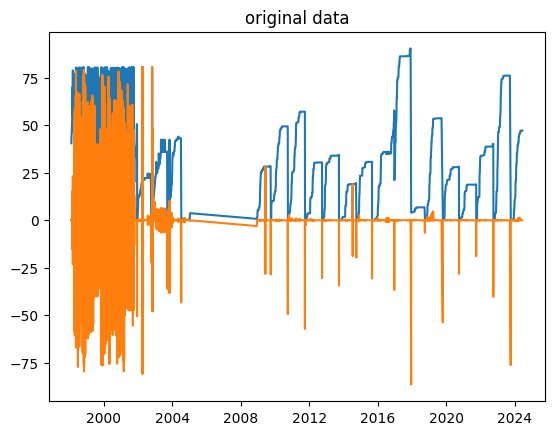

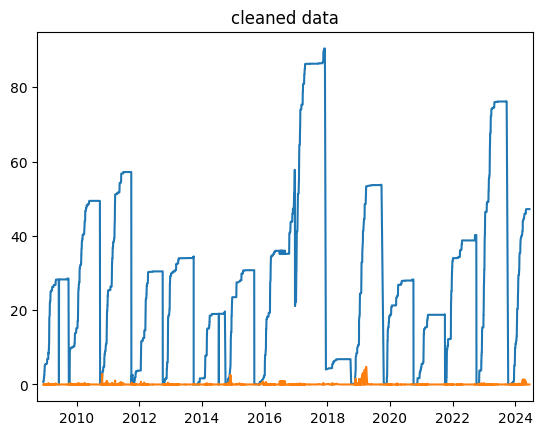

In [135]:
##use this plot code to explore data and iterate on cleaning above. I rerun multiple times to look at various parts of data
f, ax = plt.subplots(1, 1)
ax.plot(event_rain.dt, event_rain['value'])
ax.plot(event_rain.dt, event_rain['inc'])
ax.set_title('original data')

f, ax2 = plt.subplots(1, 1)
ax2.plot(event_rain_cleaned.dt, event_rain_cleaned['value'])
ax2.plot(event_rain_cleaned.dt, event_rain_cleaned.inc)
ax2.set_title('cleaned data')
ax2.set_xlim(pd.to_datetime('2008-10-01'), pd.to_datetime('2024-07-31'))

# ax2.xlim(pd.to_datetime('2018-08-01'), pd.to_datetime('2019-06-01'))
# ax2.ylim(-1, 5)

In [136]:
event_rain_cleaned.head()

stationId durCode  SENSOR_NUM sensorType              date  \
16292       BLN       E          16    RAINTIP   2008-12-10 3:34   
16293       BLN       E          16    RAINTIP  2008-12-10 15:34   
16294       BLN       E          16    RAINTIP   2008-12-11 3:34   
16295       BLN       E          16    RAINTIP  2008-12-11 15:34   
16296       BLN       E          16    RAINTIP   2008-12-12 3:34   

                obsDate  value dataFlag   units                  dt  inc  
16292   2008-12-10 3:34   0.71           INCHES 2008-12-10 03:34:00  0.0  
16293  2008-12-10 15:34   0.71           INCHES 2008-12-10 15:34:00  0.0  
16294   2008-12-11 3:34   0.71           INCHES 2008-12-11 03:34:00  0.0  
16295  2008-12-11 15:34   0.71           INCHES 2008-12-11 15:34:00  0.0  
16296   2008-12-12 3:34   0.71           INCHES 2008-12-12 03:34:00  0.0

In [137]:
# resample event data to 15min; check min and max are reasonable and consistent with plots above 
event_rain_cleaned.index = event_rain_cleaned.dt
rain_resample = event_rain_cleaned[['inc', 'value']].resample('1D').sum()
rain_resample.rename({'inc': 'precip_in_inc', 'value': 'precip_in_cum'}, axis=1, inplace=True)
rain_resample.describe()


precip_in_inc  precip_in_cum
count    5667.000000    5667.000000
mean        0.116917      95.145040
std         0.488784     315.878967
min         0.000000       0.000000
25%         0.000000       0.160000
50%         0.000000      37.500000
75%         0.000000      70.260000
max         9.020000    6256.500000

## Add NDWI Values
Downloaded from climateengine.org, median NDWI (Green/NIR) over the whole watershed. 
Watershed boundary from: https://purl.stanford.edu/cp847hc0870

In [138]:
ndwi = pd.read_csv('NDWI_GreenNIR_watershed.csv', parse_dates=True, index_col=0)
ndwi.columns = ['ndwi_watershed_green_nir']
ndwi.loc[pd.to_datetime('2008-10-01'), 'ndwi_watershed_green_nir'] = 0

# ndwi_resample = ndwi.resample('1D').ffill()
# ndwi_resample

## Merge; Check for missing values
Data prior to water year 2008 is very messy, discard. 
Missing precip is filled with zero 
Missing streamflow is linearly interpolated. 

In [139]:
# combine all data into one df 

hydro_data1 = pd.merge(rain_resample, streamflow, how='outer', left_index=True, right_index=True)
hydro_data = pd.merge(hydro_data1, ndwi, how='outer', left_index=True, right_index=True)
hydro_data['ndwi_watershed_green_nir'] = hydro_data['ndwi_watershed_green_nir'].ffill()

hydro_data.head()

precip_in_inc  precip_in_cum  q_cfs_peak_BT  stage_ft_BT  \
1987-10-01            NaN            NaN           41.0          NaN   
1987-10-02            NaN            NaN           10.0          NaN   
1987-10-03            NaN            NaN           11.0          NaN   
1987-10-04            NaN            NaN            9.9          NaN   
1987-10-05            NaN            NaN           10.0          NaN   

            code_q_BT code_stage_BT   tz_BT  flood_stage_BT  q_cfs_peak_SC  \
1987-10-01  [A, [91]]          None  -07:00             NaN           9.40   
1987-10-02  [A, [92]]          None  -07:00             NaN           4.90   
1987-10-03  [A, [91]]          None  -07:00             NaN           2.30   
1987-10-04  [A, [91]]          None  -07:00             NaN           0.99   
1987-10-05  [A, [92]]          None  -07:00             NaN           1.40   

            stage_ft_SC  code_q_SC code_stage_SC   tz_SC  flood_stage_SC  \
1987-10-01          NaN  [A, [91]]          None  -07:00             NaN   
1987-10-02          NaN  [A, [91]]          None  -07:00             NaN   
1987-10-03          NaN  [A, [91]]          None  -07:00             NaN   
1987-10-04          NaN  [A, [91]]          None  -07:00             NaN   
1987-10-05          NaN  [A, [91]]          None  -07:00             NaN   

            ndwi_watershed_green_nir  
1987-10-01                       NaN  
1987-10-02                       NaN  
1987-10-03                       NaN  
1987-10-04                       NaN  
1987-10-05                       NaN

In [140]:
# check for missing
hydro_data.isna().sum()

precip_in_inc               7744
precip_in_cum               7744
q_cfs_peak_BT                 88
stage_ft_BT                 7309
code_q_BT                     88
code_stage_BT               7309
tz_BT                         84
flood_stage_BT              7309
q_cfs_peak_SC                331
stage_ft_SC                 7311
code_q_SC                    331
code_stage_SC               7311
tz_SC                        320
flood_stage_SC              7311
ndwi_watershed_green_nir    7671
dtype: int64

<Axes: >

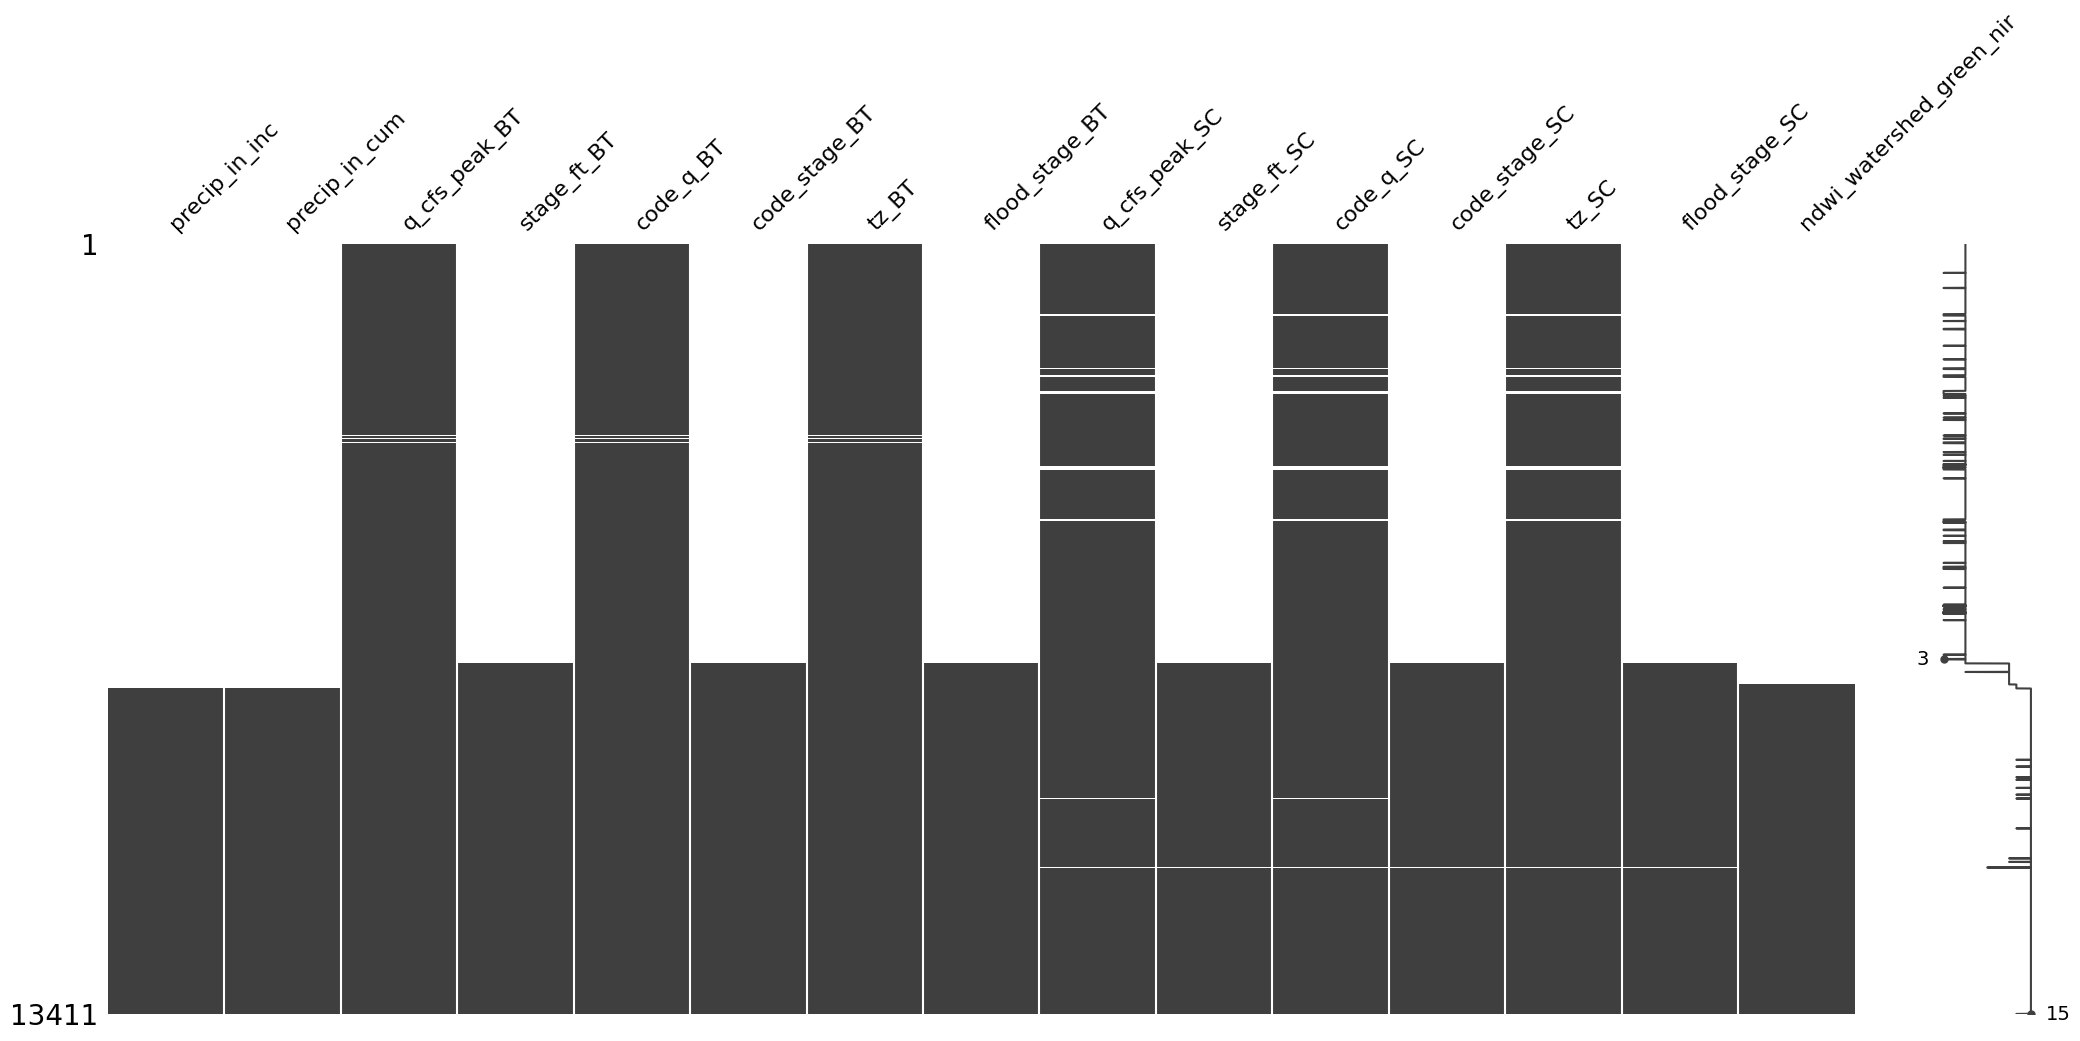

In [141]:
msno.matrix(hydro_data)

precip_in_inc               73
precip_in_cum               73
q_cfs_peak_BT                2
stage_ft_BT                  3
code_q_BT                    2
code_stage_BT                3
tz_BT                        0
flood_stage_BT               3
q_cfs_peak_SC               15
stage_ft_SC                  6
code_q_SC                   15
code_stage_SC                6
tz_SC                        4
flood_stage_SC               6
ndwi_watershed_green_nir     0
dtype: int64

<Axes: >

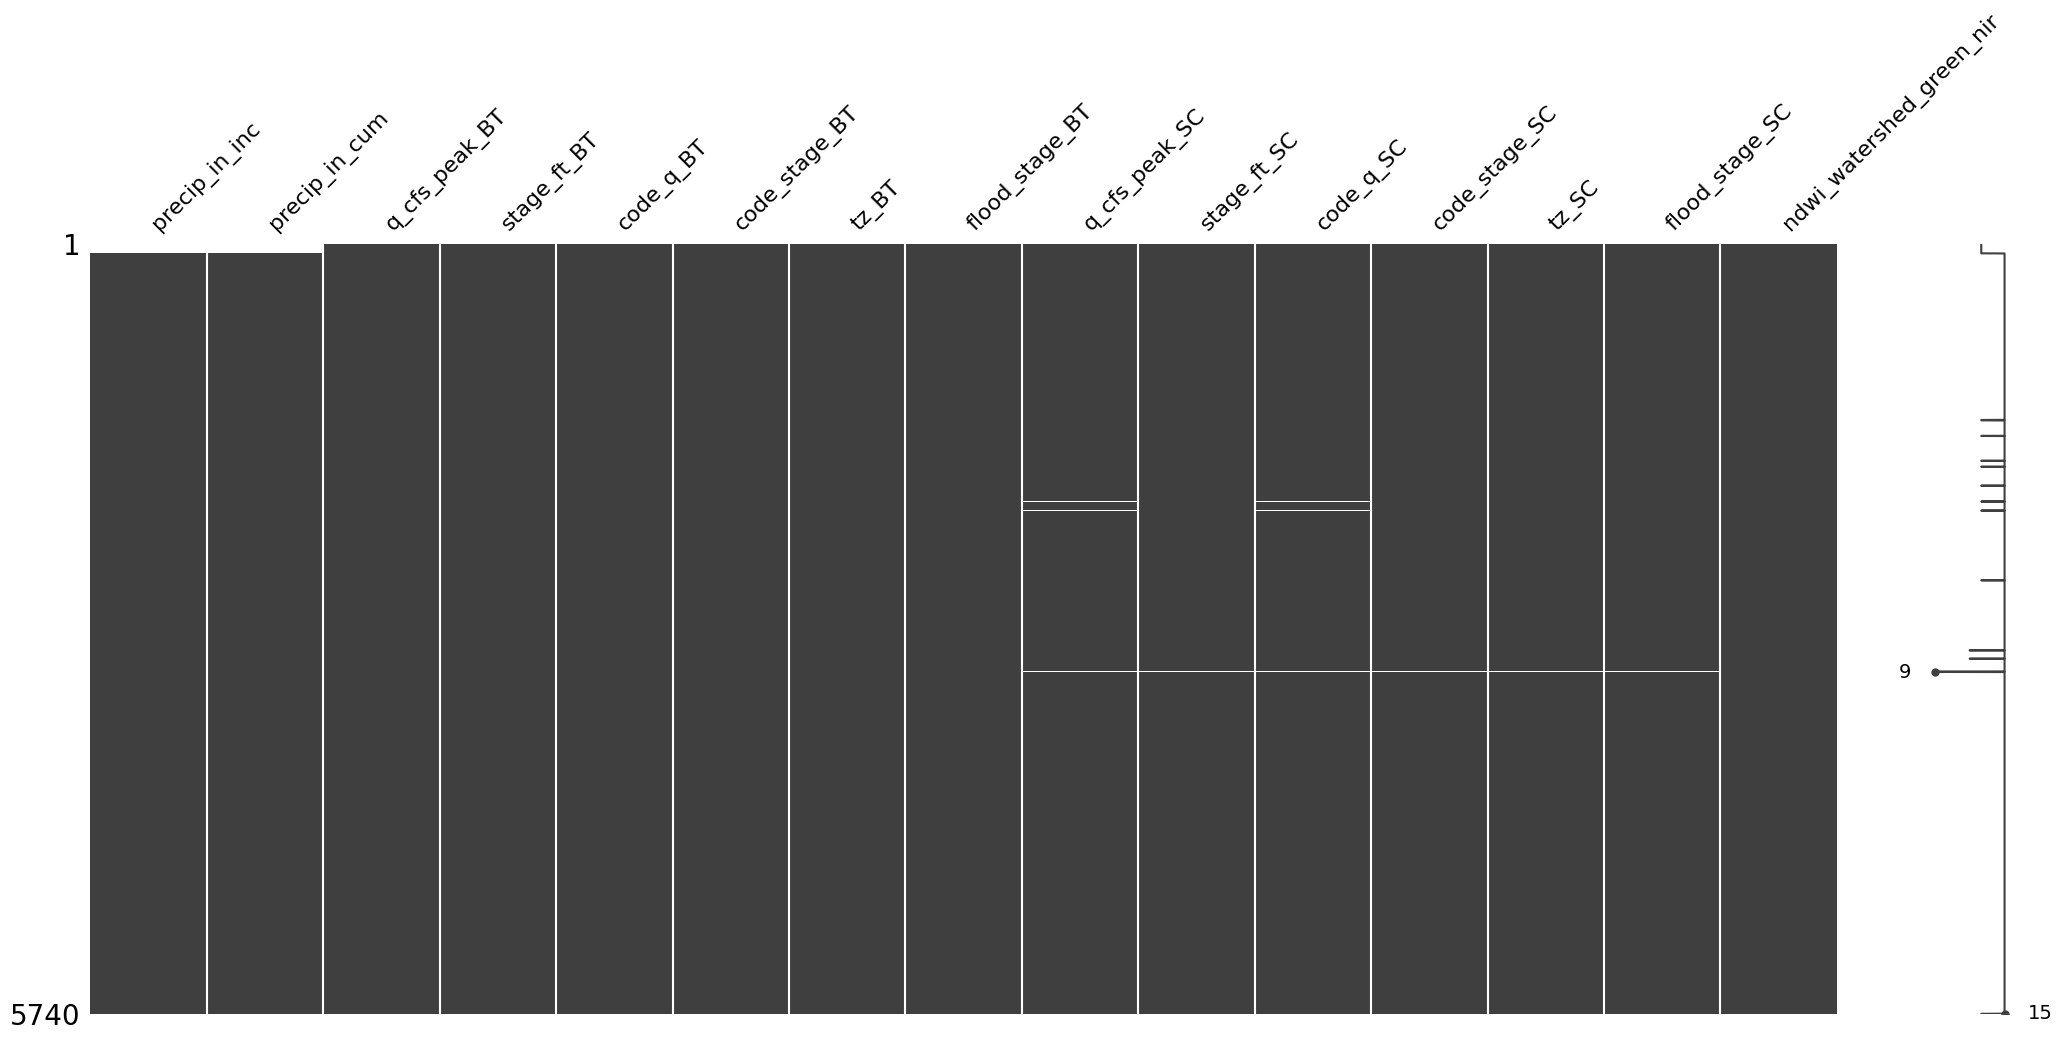

In [142]:
## keep only wy 2008 on; check for missing in that time period (much less)
hydro_data = hydro_data.loc[(hydro_data.index >= pd.to_datetime('2008-10-01'))]
display(hydro_data.isna().sum())
msno.matrix(hydro_data)

In [143]:
### fill precip with zero, it's incremental rainfall, so zero is appropriate
hydro_data.precip_in_inc = hydro_data.precip_in_inc.fillna(0)
hydro_data.loc[hydro_data.index[0], 'precip_in_cum'] = 0 #fill first precip with 0
hydro_data.precip_in_cum = hydro_data.precip_in_cum.ffill()

display(hydro_data.isna().sum())


precip_in_inc                0
precip_in_cum                0
q_cfs_peak_BT                2
stage_ft_BT                  3
code_q_BT                    2
code_stage_BT                3
tz_BT                        0
flood_stage_BT               3
q_cfs_peak_SC               15
stage_ft_SC                  6
code_q_SC                   15
code_stage_SC                6
tz_SC                        4
flood_stage_SC               6
ndwi_watershed_green_nir     0
dtype: int64

precip_in_inc               float64
precip_in_cum               float64
q_cfs_peak_BT               float64
stage_ft_BT                 float64
code_q_BT                    object
code_stage_BT                object
tz_BT                        object
flood_stage_BT              float64
q_cfs_peak_SC               float64
stage_ft_SC                 float64
code_q_SC                    object
code_stage_SC                object
tz_SC                        object
flood_stage_SC              float64
ndwi_watershed_green_nir    float64
dtype: object

<Axes: >

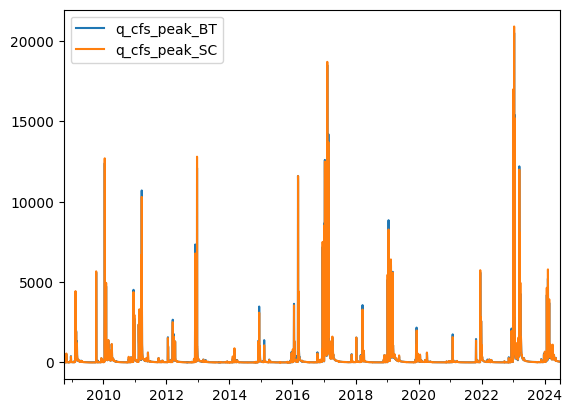

In [144]:
## code and datetime not important for modeling, so look at discharge
# hydro_data[['q_cfs_BT', 'q_cfs_SC']] = hydro_data[['q_cfs_BT', 'q_cfs_SC']].apply(pd.to_numeric)
display(hydro_data.dtypes)
hydro_data.plot(y=['q_cfs_peak_BT', 'q_cfs_peak_SC'])
# plt.yscale('log')

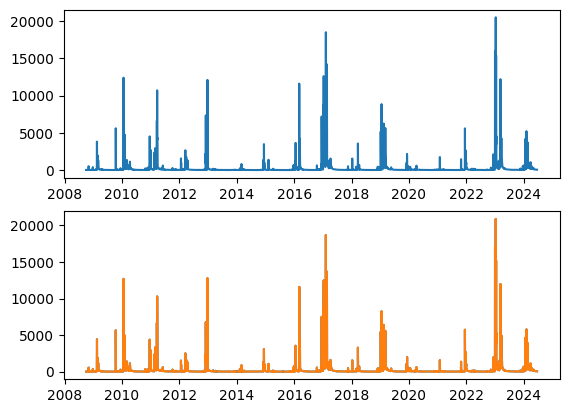

In [145]:
hydro_data[['q_cfs_peak_BT_int', 'q_cfs_peak_SC_int']] = hydro_data[['q_cfs_peak_BT', 'q_cfs_peak_SC']].interpolate()
# hydro_data[['q_cfs_BT', 'q_cfs_SC']] = hydro_data[['q_cfs_BT', 'q_cfs_SC']].fillna(-999)
f, ax = plt.subplots(2, 1)
ax[0].plot(hydro_data[['q_cfs_peak_BT']])
# ax[0].plot(hydro_data.q_cfs_BT.isna() * 10000 - 5000, linestyle='', marker='.')
ax[1].plot(hydro_data[['q_cfs_peak_SC', 'q_cfs_peak_SC_int']])
# ax[0].set_yscale('log')
# ax[0].set_xlim(pd.to_datetime('2018-04-01'), pd.to_datetime('2018-05-01'))

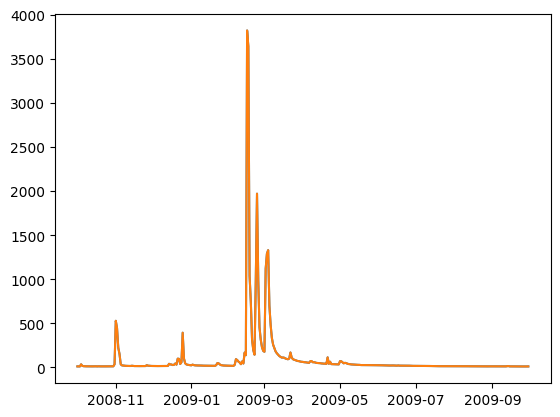

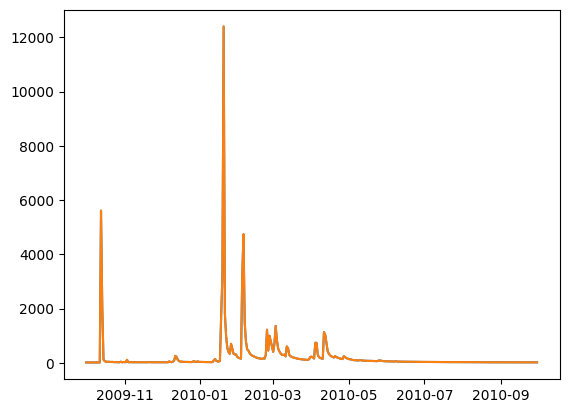

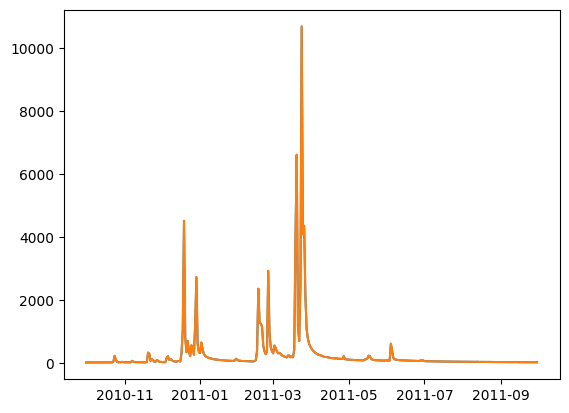

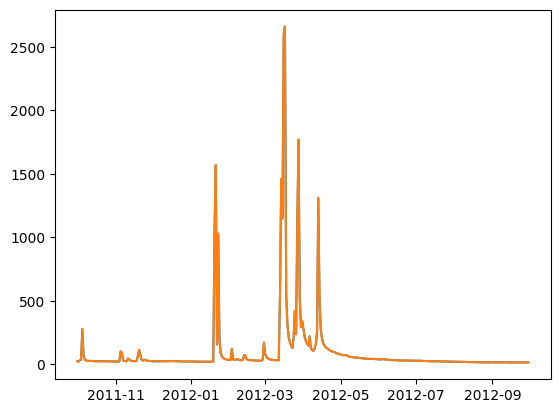

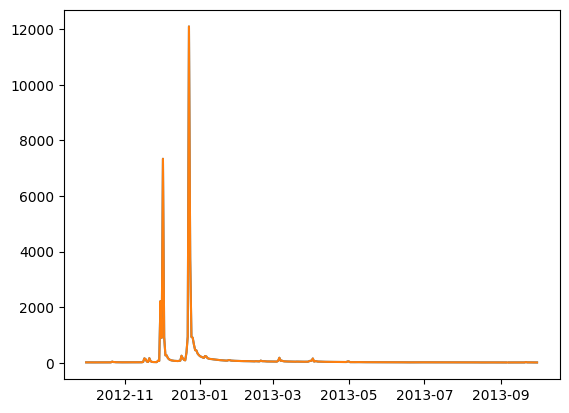

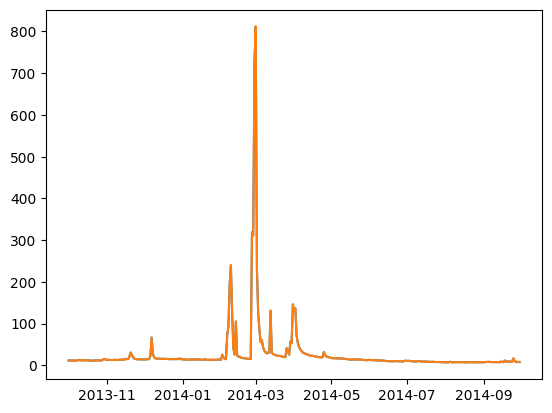

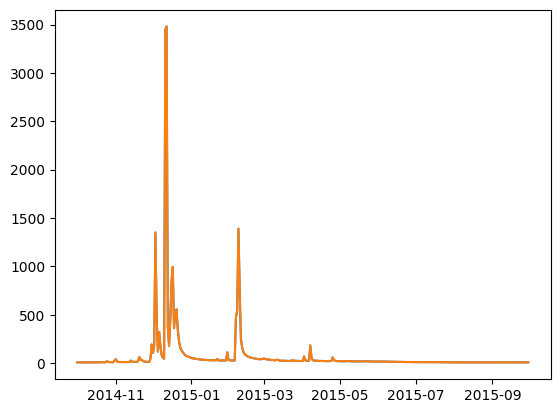

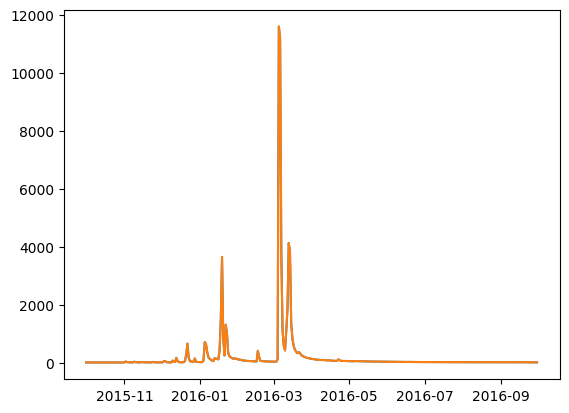

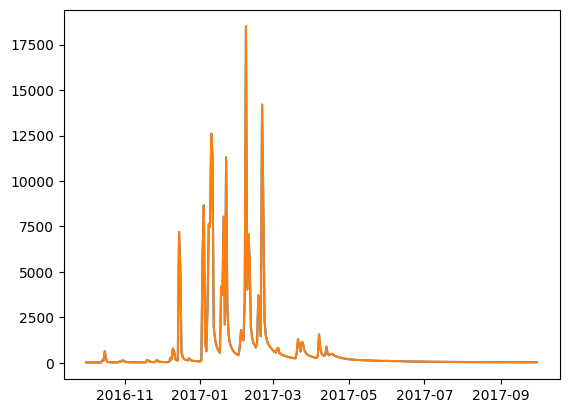

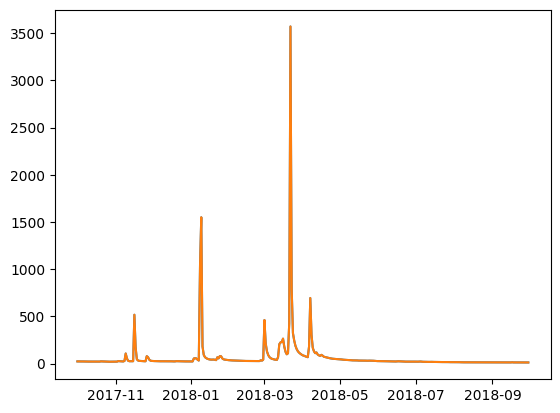

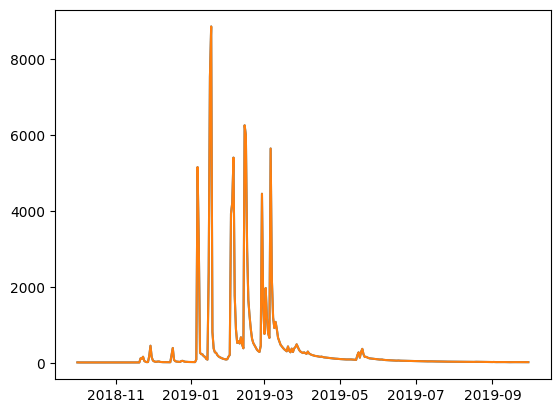

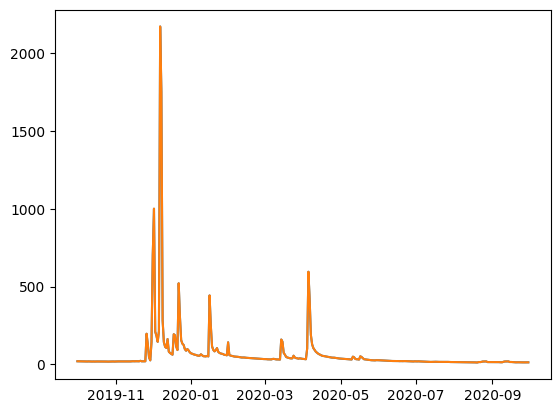

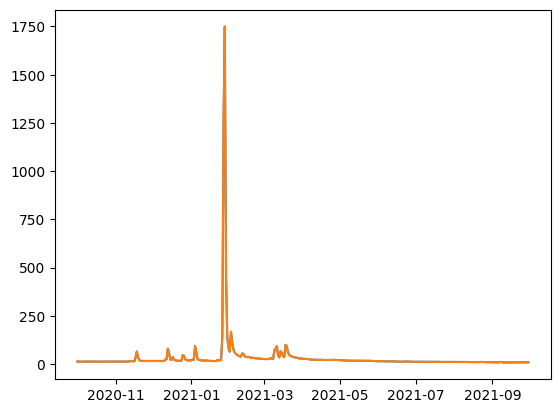

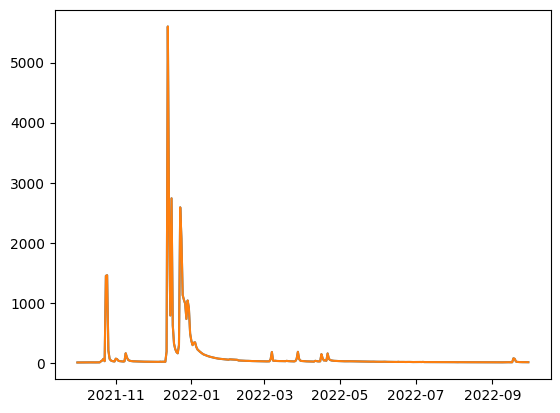

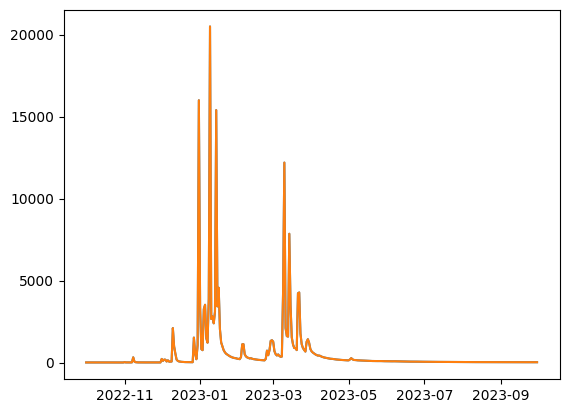

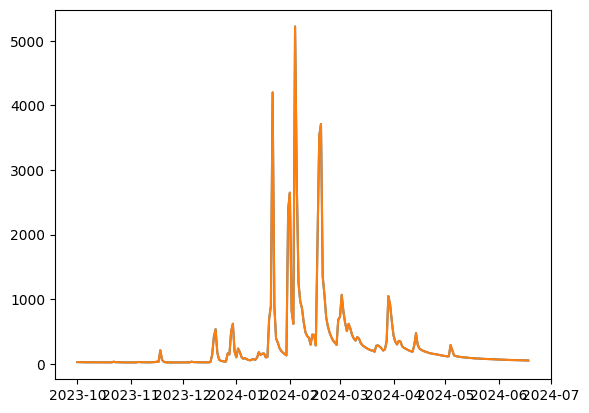

In [146]:
### plot each water year to visually check for interpolation problems

hydro_data['cy'] = hydro_data.index.year
hydro_data['month'] = hydro_data.index.month

hydro_data['wy'] = hydro_data.cy
hydro_data.loc[hydro_data['month'].isin([10, 11, 12]), 'wy'] = hydro_data.loc[hydro_data['month'].isin([10, 11, 12]), 'cy'] + 1

for wy in hydro_data['wy'].unique():
    f, ax = plt.subplots(1, 1)
    data_wy = hydro_data.loc[hydro_data['wy'] == wy, :]
    ax.plot(data_wy.index, data_wy[['q_cfs_peak_BT', 'q_cfs_peak_BT_int']])

In [147]:
#how many consecutive missing q values?
a = hydro_data[['q_cfs_peak_BT', 'q_cfs_peak_SC']].isna()
df1 = a.cumsum()-a.cumsum().where(~a).ffill().fillna(0).astype(int)
df1.max() # days


q_cfs_peak_BT    1
q_cfs_peak_SC    4
dtype: int64

In [152]:
hydro_data.isna().sum()
hydro_data_clean = hydro_data.drop(['q_cfs_peak_BT', 'code_q_BT', 'code_stage_BT', 'q_cfs_peak_SC', 'code_q_SC', 
                                    'code_stage_SC', 'tz_BT', 'tz_SC'], axis=1)

hydro_data_clean

precip_in_inc  precip_in_cum  stage_ft_BT  flood_stage_BT  \
2008-10-01            0.0           0.00         2.86             0.0   
2008-10-02            0.0           0.00         2.84             0.0   
2008-10-03            0.0           0.00         2.85             0.0   
2008-10-04            0.0           0.00         3.35             0.0   
2008-10-05            0.0           0.00         3.02             0.0   
...                   ...            ...          ...             ...   
2024-06-14            0.0           0.00         3.85             0.0   
2024-06-15            0.0          47.19         3.83             0.0   
2024-06-16            0.0          47.19         3.82             0.0   
2024-06-17            0.0          47.19         3.81             0.0   
2024-06-18            0.0          47.19         3.78             0.0   

            stage_ft_SC  flood_stage_SC  ndwi_watershed_green_nir  \
2008-10-01         3.91             0.0                    0.0000   
2008-10-02         3.97             0.0                    0.0000   
2008-10-03         3.94             0.0                   -0.3965   
2008-10-04         4.94             0.0                   -0.3965   
2008-10-05         4.95             0.0                   -0.3965   
...                 ...             ...                       ...   
2024-06-14         2.73             0.0                   -0.7155   
2024-06-15         2.68             0.0                   -0.7155   
2024-06-16         2.69             0.0                   -0.7155   
2024-06-17         2.69             0.0                   -0.7088   
2024-06-18         2.65             0.0                   -0.7088   

            q_cfs_peak_BT_int  q_cfs_peak_SC_int    cy  month    wy  
2008-10-01               12.2               1.43  2008     10  2009  
2008-10-02               11.6               2.01  2008     10  2009  
2008-10-03               11.9               1.61  2008     10  2009  
2008-10-04               35.6              23.80  2008     10  2009  
2008-10-05               18.2              24.40  2008     10  2009  
...                       ...                ...   ...    ...   ...  
2024-06-14               57.6              59.90  2024      6  2024  
2024-06-15               56.4              56.10  2024      6  2024  
2024-06-16               55.8              57.00  2024      6  2024  
2024-06-17               55.2              57.00  2024      6  2024  
2024-06-18               53.4              53.70  2024      6  2024  

[5740 rows x 12 columns]

## Check for outliers
Weird binning makes date features look uneven, but they aren't. Verified below. 

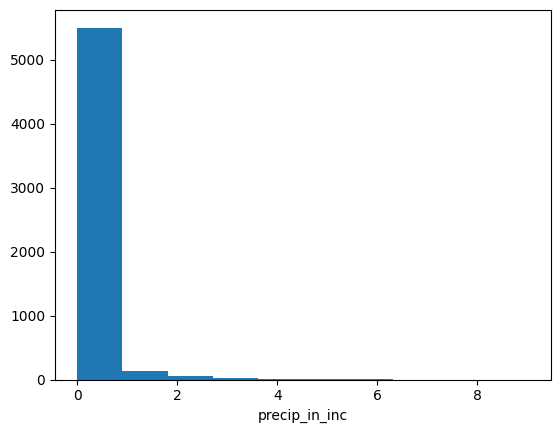

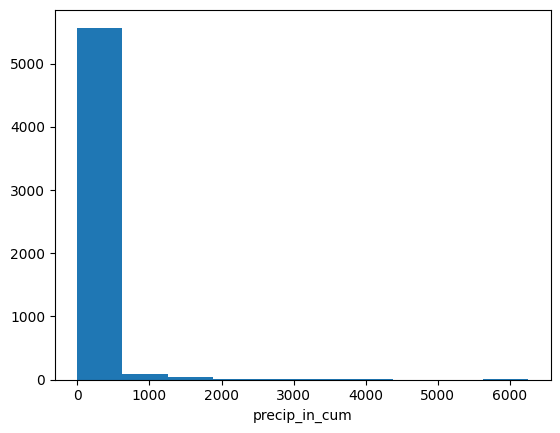

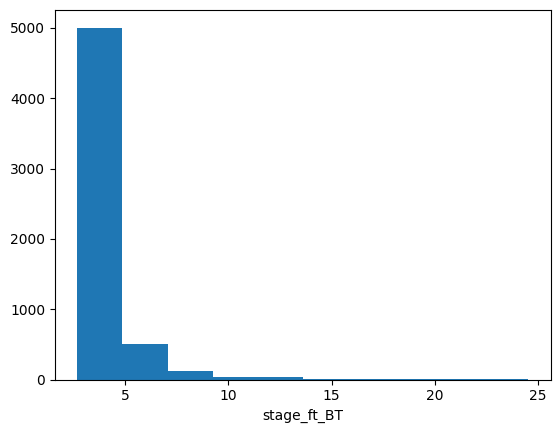

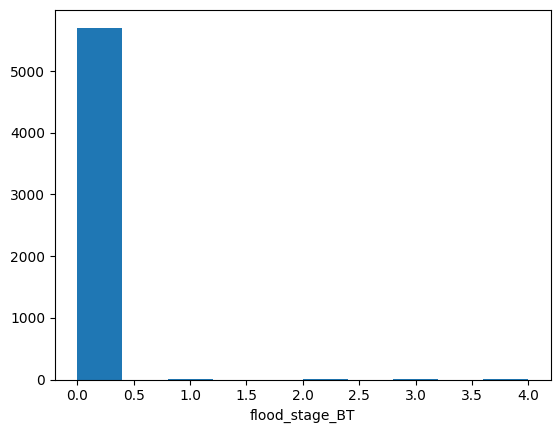

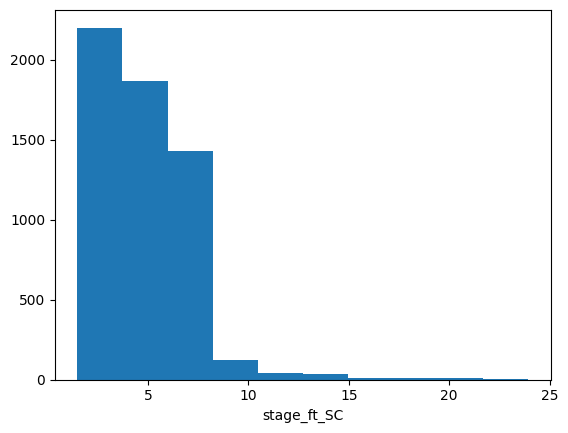

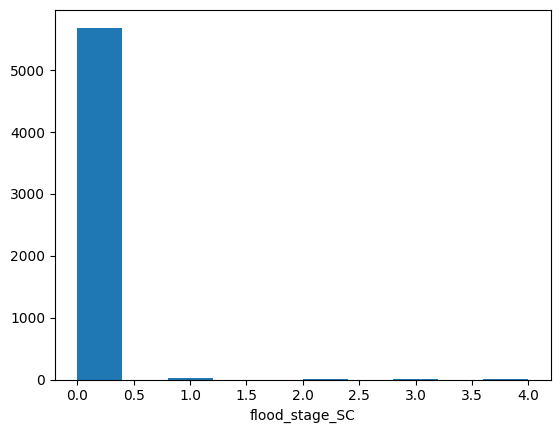

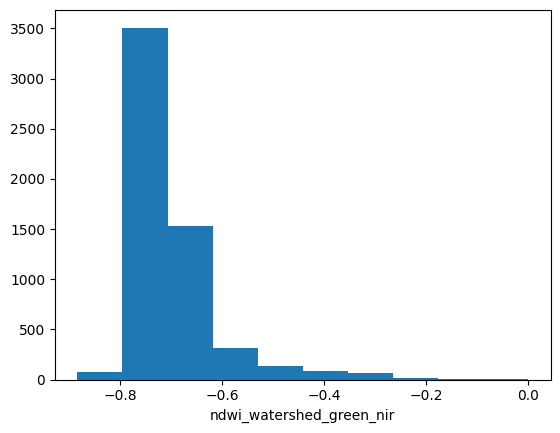

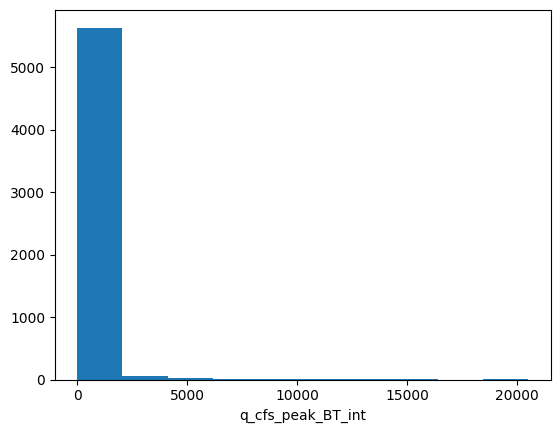

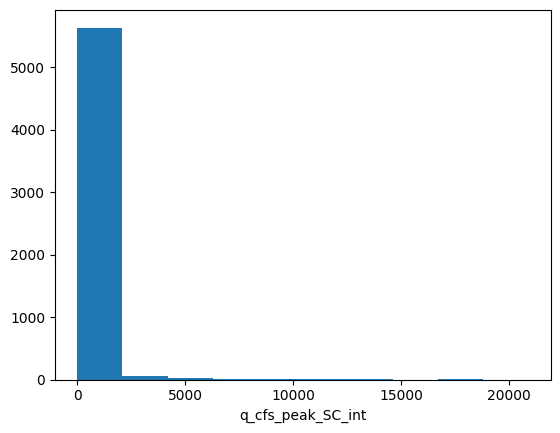

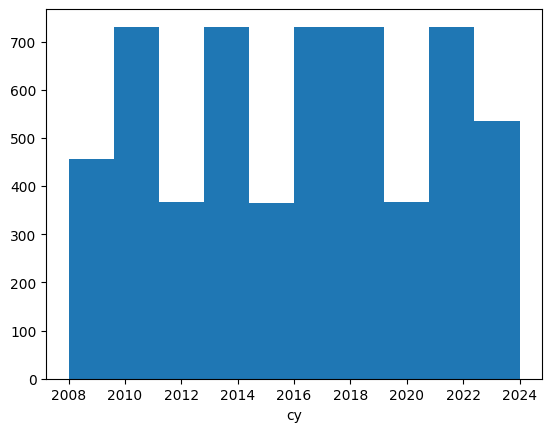

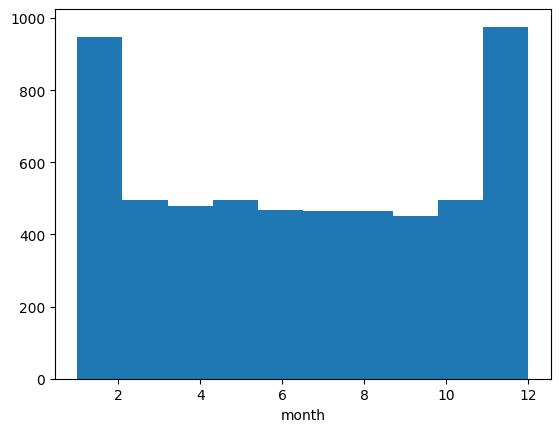

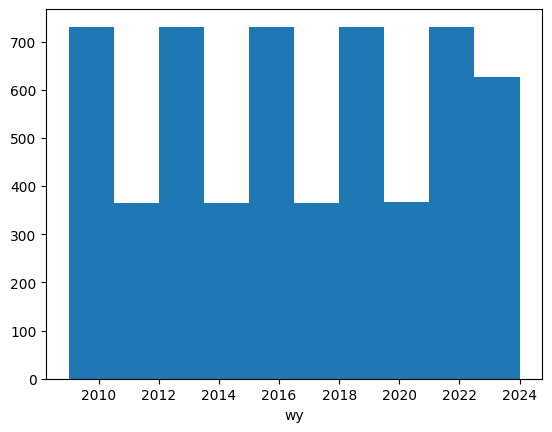

In [153]:
##outliers

for n in hydro_data_clean.columns:
    f, ax = plt.subplots(1, 1)
    ax.hist(hydro_data_clean[n])
    ax.set_xlabel(n)

# hydro_data_clean.head(20)

In [154]:
n

'wy'

In [155]:
print('timestamp duplicates: ', hydro_data_clean.index.duplicated().sum())
display(hydro_data_clean.wy.value_counts())
display(hydro_data_clean.month.value_counts())

## no timestamp duplicates. Weird spikey histograms are binning issues. 

timestamp duplicates:  0


wy
2012    366
2016    366
2020    366
2009    365
2010    365
2011    365
2013    365
2014    365
2015    365
2017    365
2018    365
2019    365
2021    365
2022    365
2023    365
2024    262
Name: count, dtype: int64

month
10    496
12    496
1     496
3     496
5     496
11    480
4     480
6     468
7     465
8     465
2     452
9     450
Name: count, dtype: int64

## Add relevant wildfires and estimate percent of watershed burned. 

In [156]:
## wildfires
wildfire_percent = {2017: 341.136 / 88320.0, # https://data-nifc.opendata.arcgis.com/datasets/nifc::historic-perimeters-combined-2000-2018-geomac/about
                   2020: 0.2} # https://www.cityofsantacruz.com/government/city-departments/water/water-quality/czu-fire-water-quality

# wildfire_percent = pd.DataFrame(wildfire_percent, index=[0, 1])
wildfire_percent

{2017: 0.0038625000000000005, 2020: 0.2}

## Download drought index data 
from https://www.drought.gov/historical-information?dataset=0&selectedDateUSDM=20240618
for Santa Cruz County

In [157]:
#drought data, SC county

drought_data = pd.read_csv('USDM-06087.csv', parse_dates=['ValidStart', 'ValidEnd'])
drought_data.rename({'ValidStart': 'week_start'}, axis=1, inplace=True)
drought_data.index = drought_data.week_start
drought_data = drought_data[['D0', 'D1', 'D2', 'D3', 'D4']].copy()
drought_data = drought_data.sort_index()
drought_data#.loc[pd.to_datetime('2008-10-01'), :]

D0   D1   D2   D3   D4
week_start                         
2000-01-04  0.0  0.0  0.0  0.0  0.0
2000-01-11  0.0  0.0  0.0  0.0  0.0
2000-01-18  0.0  0.0  0.0  0.0  0.0
2000-01-25  0.0  0.0  0.0  0.0  0.0
2000-02-01  0.0  0.0  0.0  0.0  0.0
...         ...  ...  ...  ...  ...
2024-05-21  0.0  0.0  0.0  0.0  0.0
2024-05-28  0.0  0.0  0.0  0.0  0.0
2024-06-04  0.0  0.0  0.0  0.0  0.0
2024-06-11  0.0  0.0  0.0  0.0  0.0
2024-06-18  0.0  0.0  0.0  0.0  0.0

[1277 rows x 5 columns]

In [158]:
#merge drought and wildfire data
drought_data_resample = drought_data.resample('1D').ffill()
data = pd.merge(hydro_data_clean, drought_data_resample, left_index=True, right_index=True, how='left')
data = pd.merge(hydro_data_clean, drought_data_resample, left_index=True, right_index=True, how='left')

for k in wildfire_percent.keys():
    data.loc[data['wy'] == k, 'wildfire_percent'] = wildfire_percent[k]

data[['wildfire_percent']] = data[['wildfire_percent']].fillna(0)
data.head()

precip_in_inc  precip_in_cum  stage_ft_BT  flood_stage_BT  \
2008-10-01            0.0            0.0         2.86             0.0   
2008-10-02            0.0            0.0         2.84             0.0   
2008-10-03            0.0            0.0         2.85             0.0   
2008-10-04            0.0            0.0         3.35             0.0   
2008-10-05            0.0            0.0         3.02             0.0   

            stage_ft_SC  flood_stage_SC  ndwi_watershed_green_nir  \
2008-10-01         3.91             0.0                    0.0000   
2008-10-02         3.97             0.0                    0.0000   
2008-10-03         3.94             0.0                   -0.3965   
2008-10-04         4.94             0.0                   -0.3965   
2008-10-05         4.95             0.0                   -0.3965   

            q_cfs_peak_BT_int  q_cfs_peak_SC_int    cy  month    wy     D0  \
2008-10-01               12.2               1.43  2008     10  2009  100.0   
2008-10-02               11.6               2.01  2008     10  2009  100.0   
2008-10-03               11.9               1.61  2008     10  2009  100.0   
2008-10-04               35.6              23.80  2008     10  2009  100.0   
2008-10-05               18.2              24.40  2008     10  2009  100.0   

               D1   D2   D3   D4  wildfire_percent  
2008-10-01  100.0  0.0  0.0  0.0               0.0  
2008-10-02  100.0  0.0  0.0  0.0               0.0  
2008-10-03  100.0  0.0  0.0  0.0               0.0  
2008-10-04  100.0  0.0  0.0  0.0               0.0  
2008-10-05  100.0  0.0  0.0  0.0               0.0

In [159]:
data.loc[data['ndwi_watershed_green_nir'].isna(), 'ndwi_watershed_green_nir']

Series([], Freq: D, Name: ndwi_watershed_green_nir, dtype: float64)

In [160]:
#final nan/duplicate checks

display(data.isna().sum())
print('duplicates: ', data.index.duplicated().sum())

precip_in_inc               0
precip_in_cum               0
stage_ft_BT                 3
flood_stage_BT              3
stage_ft_SC                 6
flood_stage_SC              6
ndwi_watershed_green_nir    0
q_cfs_peak_BT_int           0
q_cfs_peak_SC_int           0
cy                          0
month                       0
wy                          0
D0                          0
D1                          0
D2                          0
D3                          0
D4                          0
wildfire_percent            0
dtype: int64

duplicates:  0


## Check variable correlations
Will likely use LSTM so checking lagged correlation as well

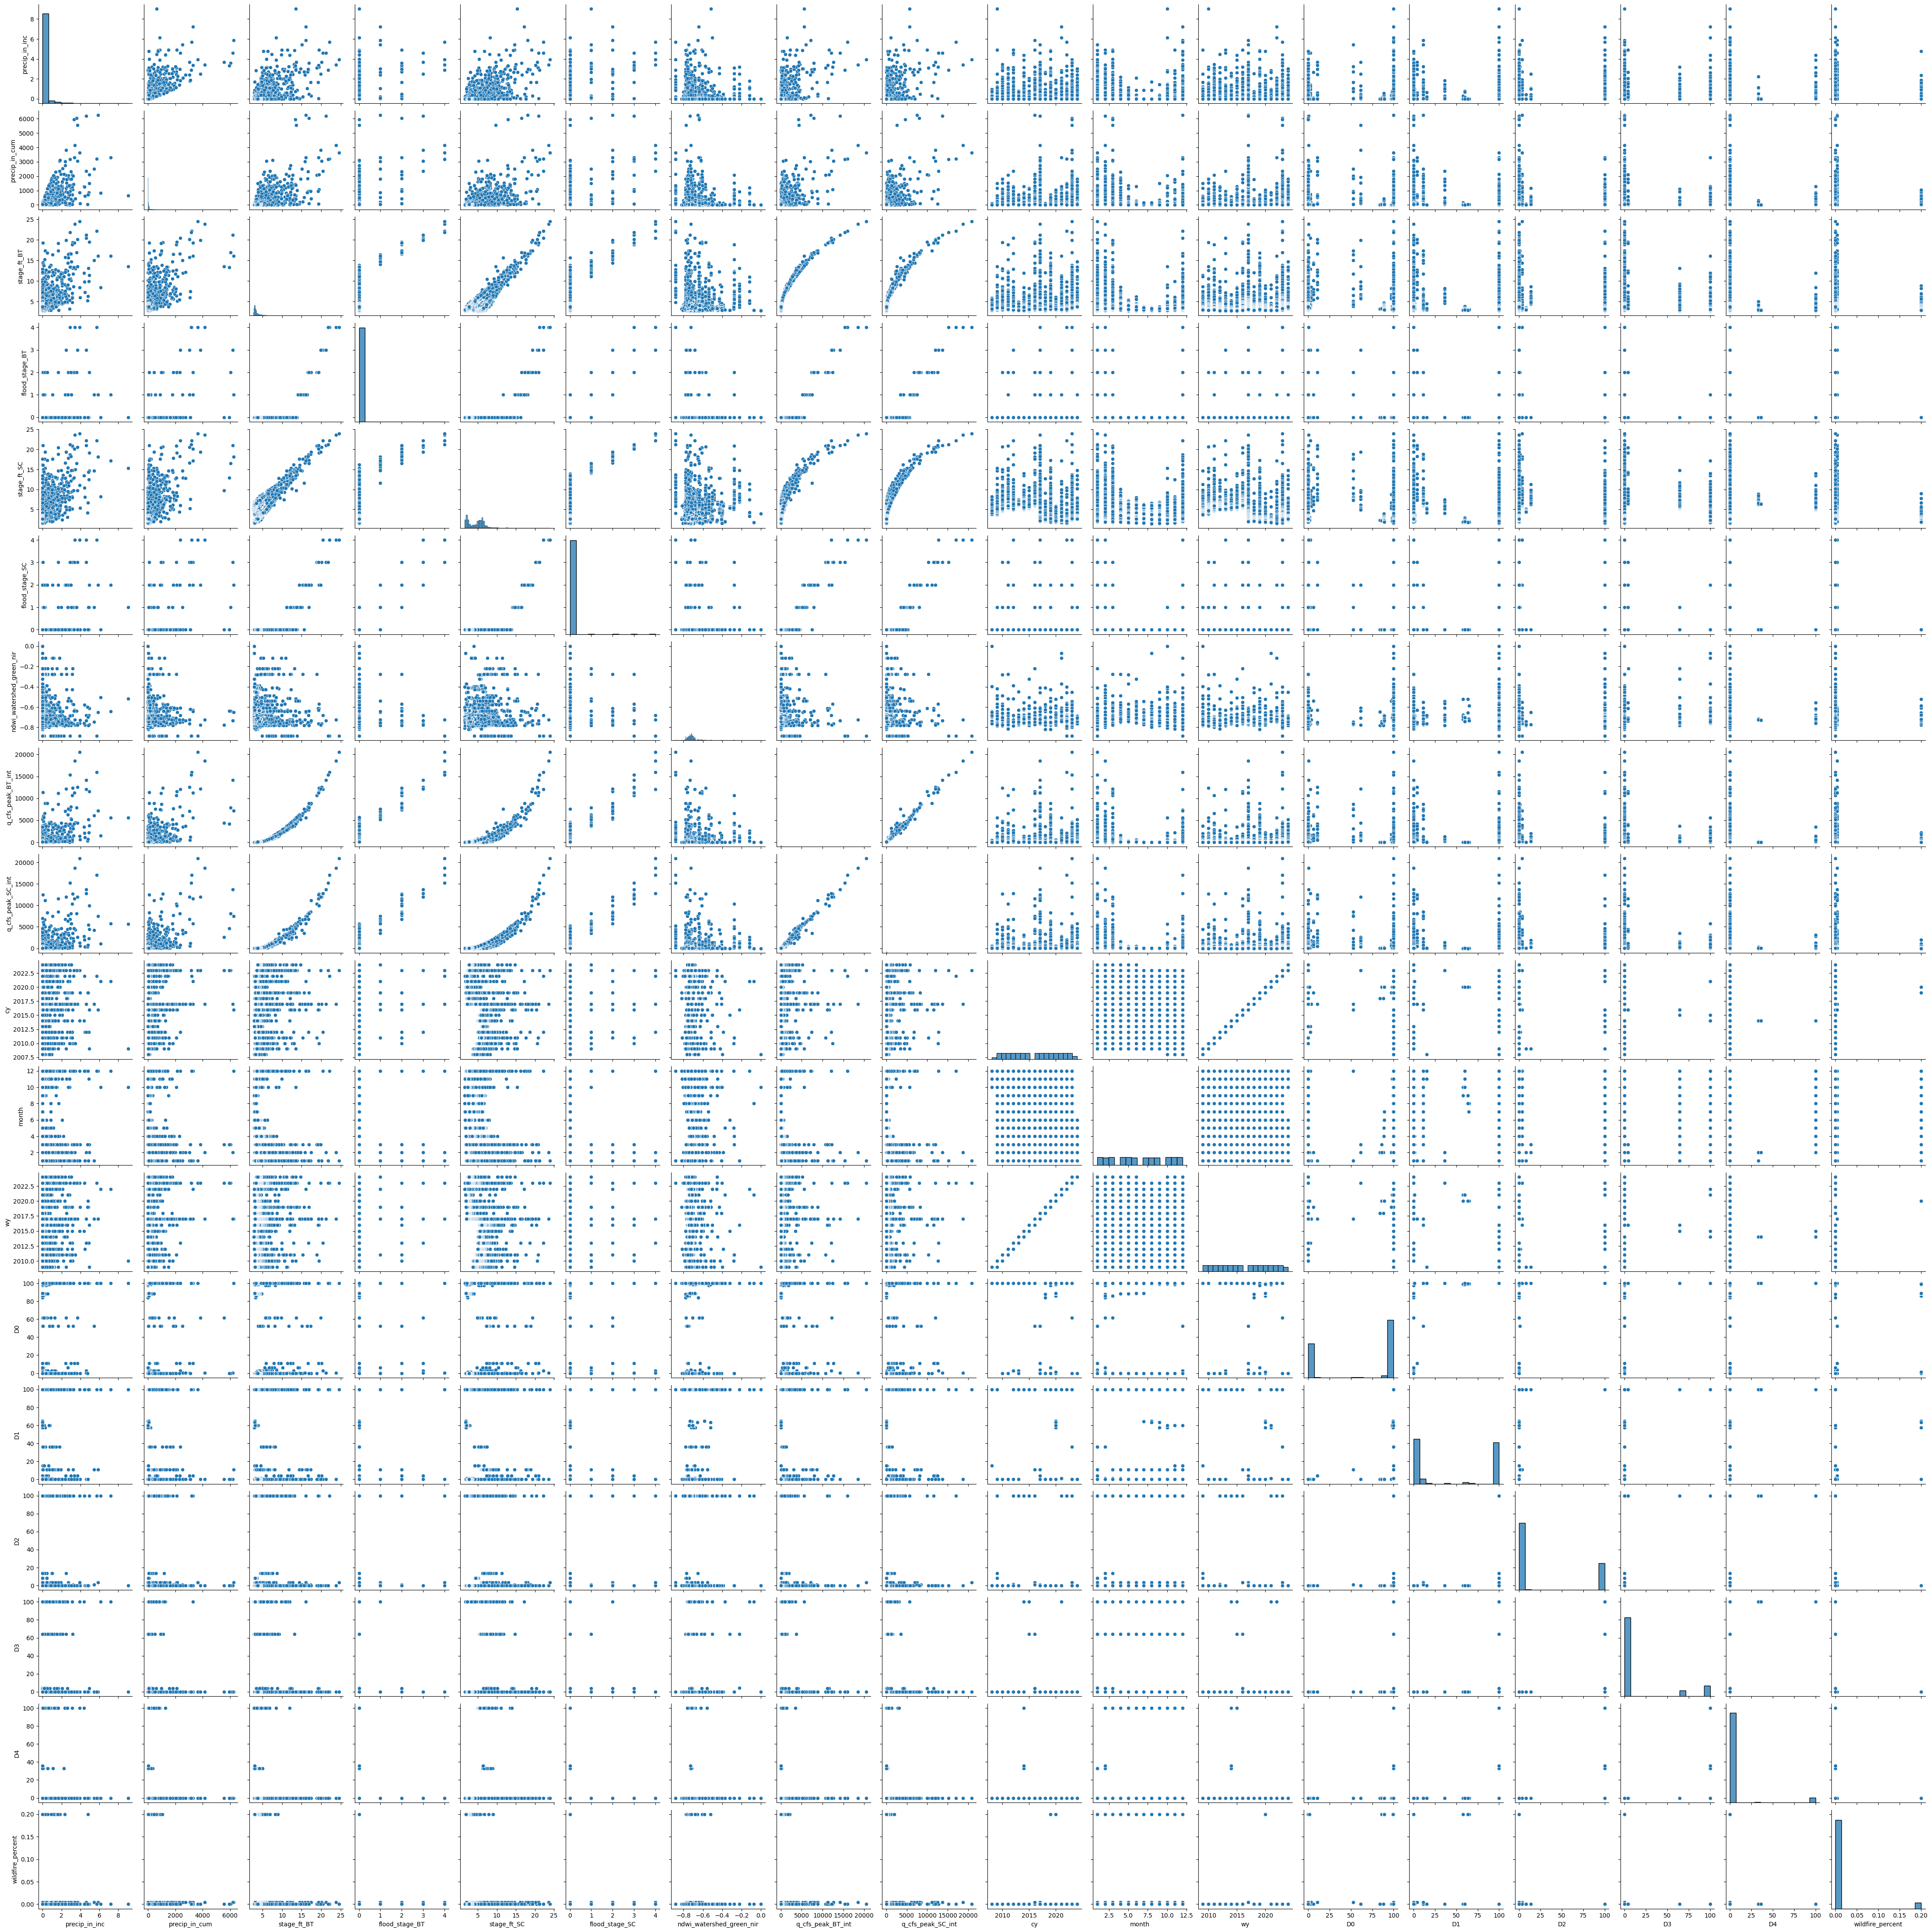

In [161]:
#plot var correlations
sns.pairplot(data)

<Axes: >

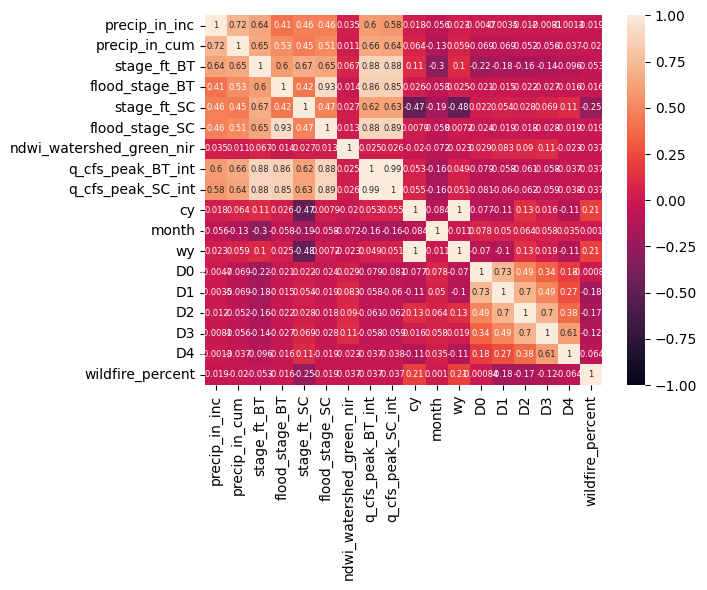

In [162]:
# plot correlation heatmap
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, annot_kws={"size":6}) 

lag correlation
0      0    0.575809
1      1    0.443695
15    15    0.406518
29    29    0.404343
43    43    0.418309
57    57    0.413349
71    71     0.41693
85    85    0.443285
99    99    0.437558
113  113     0.43787
127  127     0.44668
141  141    0.446443
155  155    0.448881
169  169    0.443146
183  183    0.447005
197  197    0.444088
211  211    0.443379
225  225    0.430359
239  239    0.426511
253  253    0.437454

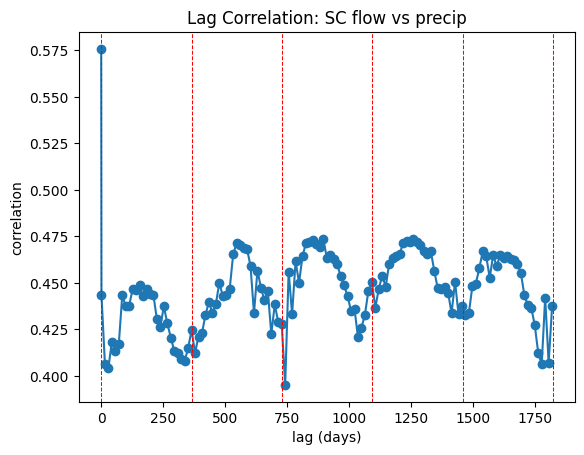

In [163]:
# calc lag correlation w precip, plot
lag_step = np.arange(1, 365*5, 14)
lag_step
lags_out = pd.DataFrame(columns=['lag', 'correlation'])
lags_out.loc[0, :] = [0, np.corrcoef(data['q_cfs_peak_SC_int'], data['precip_in_inc'])[1,0]]
for lag in lag_step:
    data_lag = data.copy()
    data_lag['q_cfs_peak_BT_int'] = data_lag['q_cfs_peak_BT_int'].diff(lag)
    data_lag.dropna(inplace=True)
    lags_out.loc[lag, :] = [lag, np.corrcoef(data_lag['q_cfs_peak_BT_int'], data_lag['precip_in_inc'])[1,0]]
    
f, ax = plt.subplots(1, 1)
ax.plot(lags_out['lag'], lags_out['correlation'],  linestyle='-', marker='o')
ax.set_ylabel('correlation')
ax.set_xlabel('lag (days)')
ax.set_title('Lag Correlation: SC flow vs precip')
for x in np.arange(0, 6*365, 365):
    ax.axvline(x, c='r', linestyle='--', linewidth=0.75)
lags_out.head(20)

lag correlation
0      0    0.026433
1      1   -0.000187
15    15    0.009401
29    29   -0.005614
43    43   -0.011478
57    57    0.005463
71    71    0.010607
85    85    0.024667
99    99    0.026223
113  113    0.030198
127  127     0.03668
141  141    0.037952
155  155    0.051105
169  169    0.042605
183  183    0.052504
197  197    0.056005
211  211    0.063704
225  225    0.060841
239  239    0.053815
253  253    0.056224

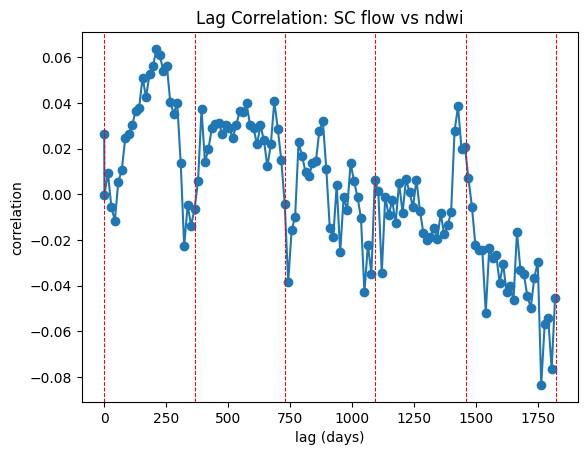

In [164]:
# calc lag correlation with ndwi, plot
lag_step = np.arange(1, 365*5, 14)
lag_step
lags_out = pd.DataFrame(columns=['lag', 'correlation'])
lags_out.loc[0, :] = [0, np.corrcoef(data['q_cfs_peak_SC_int'], data['ndwi_watershed_green_nir'])[1,0]]
for lag in lag_step:
    data_lag = data.copy()
    data_lag['q_cfs_peak_BT_int'] = data_lag['q_cfs_peak_BT_int'].diff(lag)
    data_lag.dropna(inplace=True)
    lags_out.loc[lag, :] = [lag, np.corrcoef(data_lag['q_cfs_peak_BT_int'], data_lag['ndwi_watershed_green_nir'])[1,0]]
    
f, ax = plt.subplots(1, 1)
ax.plot(lags_out['lag'], lags_out['correlation'],  linestyle='-', marker='o')
ax.set_ylabel('correlation')
ax.set_xlabel('lag (days)')
ax.set_title('Lag Correlation: SC flow vs ndwi')
for x in np.arange(0, 6*365, 365):
    ax.axvline(x, c='r', linestyle='--', linewidth=0.75)
lags_out.head(20)

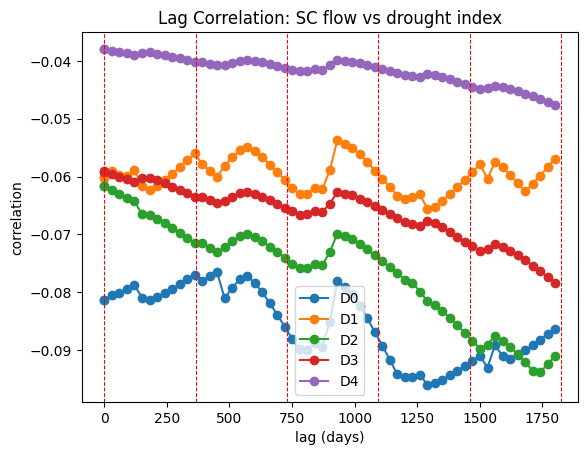

In [165]:
#lag correlation with each Drought category
lag_step = np.arange(1, 365*5, 30)
d_cat_list = ['D0', 'D1', 'D2', 'D3', 'D4']
lags_out = pd.DataFrame(columns=d_cat_list)

for d in d_cat_list:
    lags_out.loc[0, d] = np.corrcoef(data['q_cfs_peak_SC_int'], data[d])[1,0]
    
for lag in lag_step:
    data_lag = data.copy()
    data_lag['q_cfs_peak_BT_int'] = data_lag['q_cfs_peak_BT_int'].diff(lag)
    data_lag.dropna(inplace=True)
    
    for d in d_cat_list:
        lags_out.loc[lag, d] = np.corrcoef(data_lag['q_cfs_peak_SC_int'], data_lag[d])[1,0]

    
f, ax = plt.subplots(1, 1)
ax.plot(lags_out.index, lags_out,  linestyle='-', marker='o')
ax.set_ylabel('correlation')
ax.set_xlabel('lag (days)')
ax.legend(lags_out.columns)
ax.set_title('Lag Correlation: SC flow vs drought index')

for x in np.arange(0, 6*365, 365):
    ax.axvline(x, c='r', linestyle='--', linewidth=0.75)

In [166]:
#save data
data.to_csv('01_data.csv')

## Summary
Data resampled to daily - laptop kernel was crashing with 15 min data when running model

No missing data or outliers. 
Lag correlations suggest that precipitation and streamflow correlation peaks about 4 months prior, so will need to look back at least 4 months for LSTM models. 
Drought index vs streamflow shows similar results; with small bumps in correlation around 4 months prior. 

Other potential data to add if model doesn't perform well: precipitation or humidity. Soil moisture metric? Maybe watershed scale NDWI? 